# Building (Peak vs. Off Peak) Histograms

### How to run this notebook:
* Give date and type of vehicle as arguments
* If simplified etapas file does not exist, then run RunDailyEtapasBuilder.runSimplifyEtapas(). If it already exists, then omit it
* If simplified perfiles file does not exist, then run RunDailyEtapasBuilder.runSimplifyPerfiles(). If it already exists, then omit it. TODO: This is not (yet) needed

Run the builder in this order:
1. etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
2. merged_df = RunDailyEtapasBuilder.includeTorniquetesDate(etapas_df)
3. clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
4. sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt

In [2]:
import RunDailyEtapasBuilder

Enter the date to analyze: 2017-03-01
Enter the vehicle to analyze: BUS
Consider ZP in perfiles file (0/1)?: 0


* Running the builder of the dataframe

In [3]:
#RunDailyEtapasBuilder.runSimplifyEtapas()
etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
merged_df = RunDailyEtapasBuilder.mergeTurnstileData(etapas_df)
clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)
sorted_df = sorted_df.reset_index()

Not found in turnstile database: 1614656


* Counting.

In [4]:
print(etapas_df['id'].count())
print(merged_df['id'].count())
print(clean_df['id'].count())
print(sorted_df['id'].count())

2329229
2329229
2210399
2210399


* Adding necessary attributes

In [5]:
sorted_df['mismo_paradero'] = (sorted_df['par_subida']==sorted_df['par_subida'].shift()).fillna(False)
sorted_df['misma_patente'] = (sorted_df['sitio_subida']==sorted_df['sitio_subida'].shift()).fillna(False)
sorted_df['mismo_servicio'] = (sorted_df['servicio_subida']==sorted_df['servicio_subida'].shift()).fillna(False)

sorted_df.loc[(sorted_df.mismo_servicio == True) & (sorted_df.mismo_paradero == True) & (sorted_df.misma_patente == True), 'diferencia_tiempo'] = (sorted_df['t_subida']-sorted_df['t_subida'].shift())

sorted_df['diferencia_tiempo_secs'] = sorted_df['diferencia_tiempo'].dt.total_seconds()
sorted_df['si_torniquete'] = (sorted_df['fecha_instalacion']<=sorted_df['t_subida'])
sorted_df['si_2017_torniquete'] = ((sorted_df['fecha_instalacion']<=sorted_df['t_subida'])&(sorted_df['fecha_instalacion']>=pd.to_datetime('2017-01-01')))

* Filtering by mismo_paradero, misma_patente and by si_torniquete. This is a key part

In [6]:
filtered_df = sorted_df[(sorted_df.mismo_servicio==True) & (sorted_df.mismo_paradero==True) & (sorted_df.misma_patente==True)]
filtered_turnstile_df = filtered_df[filtered_df.si_2017_torniquete==True]
filtered_no_turnstile_df = filtered_df[filtered_df.si_torniquete==False]

* Counting and checking

In [7]:
print(filtered_df['id'].count())
print(filtered_turnstile_df['id'].count())
print(filtered_no_turnstile_df['id'].count())
checking = filtered_turnstile_df['id'].count() + filtered_no_turnstile_df['id'].count()
print(checking)

1380689
285058
1095631
1380689


* Getting rid of unecessary dataframes

In [8]:
del etapas_df
del merged_df
del clean_df

* Filtering by period (peak vs. off-peak). In this case, peak is PMA + PTA

In [9]:
off_peak_start_1 = dt.time(0,0,0)
off_peak_end_1 = dt.time(6,29,0)

peak_start_1 = dt.time(6,30,0)
peak_end_1 = dt.time(8,29,0)

off_peak_start_2 = dt.time(8,30,0)
off_peak_end_2 = dt.time(17,29,0)

peak_start_2 = dt.time(17,30,0)
peak_end_2 = dt.time(20,29,0)

off_peak_start_3 = dt.time(20,30,0)
off_peak_end_3 = dt.time(23,59,0)

* TODO: Consider reducing this

In [10]:
off_peak_turnstile_df = filtered_turnstile_df[((off_peak_start_1<=filtered_turnstile_df['t_subida'].dt.time)
                                               & (filtered_turnstile_df['t_subida'].dt.time<=off_peak_end_1))
                                               | ((off_peak_start_2<=filtered_turnstile_df['t_subida'].dt.time)
                                               & (filtered_turnstile_df['t_subida'].dt.time<=off_peak_end_2))
                                               | ((off_peak_start_3<=filtered_turnstile_df['t_subida'].dt.time)
                                               & (filtered_turnstile_df['t_subida'].dt.time<=off_peak_end_3))]

off_peak_no_turnstile_df = filtered_no_turnstile_df[((off_peak_start_1<=filtered_no_turnstile_df['t_subida'].dt.time)
                                               & (filtered_no_turnstile_df['t_subida'].dt.time<=off_peak_end_1))
                                               | ((off_peak_start_2<=filtered_no_turnstile_df['t_subida'].dt.time)
                                               & (filtered_no_turnstile_df['t_subida'].dt.time<=off_peak_end_2))
                                               | ((off_peak_start_3<=filtered_no_turnstile_df['t_subida'].dt.time)
                                               & (filtered_no_turnstile_df['t_subida'].dt.time<=off_peak_end_3))]

peak_turnstile_df = filtered_turnstile_df[((peak_start_1<=filtered_turnstile_df['t_subida'].dt.time)
                                           & (filtered_turnstile_df['t_subida'].dt.time<=peak_end_1))
                                           | ((peak_start_2<=filtered_turnstile_df['t_subida'].dt.time)
                                           & (filtered_turnstile_df['t_subida'].dt.time<=peak_end_2))]

peak_no_turnstile_df = filtered_no_turnstile_df[((peak_start_1<=filtered_no_turnstile_df['t_subida'].dt.time)
                                           & (filtered_no_turnstile_df['t_subida'].dt.time<=peak_end_1))
                                           | ((peak_start_2<=filtered_no_turnstile_df['t_subida'].dt.time)
                                           & (filtered_no_turnstile_df['t_subida'].dt.time<=peak_end_2))]

* TODO: Currently, there are rows with extremely high values for the 'diferencia_tiempo' attribute (e.g. >=25 mins). This should be fixed considering the idExpedicion attribute present in the corresponding 'perfiles' database. The following graphs and descriptive statistics consider only the 95th percentile for the 'diferencia_tiempo_secs' attribute. 

In [11]:
off_peak_turnstile_95 = off_peak_turnstile_df.diferencia_tiempo.quantile(0.95)
print ('Percentile 95th for off_peak_turnstile database is: ' + str(off_peak_turnstile_95))
off_peak_no_turnstile_95 = off_peak_no_turnstile_df.diferencia_tiempo.quantile(0.95)
print ('Percentile 95th for off_peak_no_turnstile database is: ' + str(off_peak_no_turnstile_95))
peak_turnstile_95 = peak_turnstile_df.diferencia_tiempo.quantile(0.95)
print ('Percentile 95th for peak_turnstile database is: ' + str(peak_turnstile_95))
peak_no_turnstile_95 = peak_no_turnstile_df.diferencia_tiempo.quantile(0.95)
print ('Percentile 95th for peak_no_turnstile database is: ' + str(peak_no_turnstile_95))

Percentile 95th for off_peak_turnstile database is: 0 days 00:00:37
Percentile 95th for off_peak_no_turnstile database is: 0 days 00:00:34
Percentile 95th for peak_turnstile database is: 0 days 00:00:18
Percentile 95th for peak_no_turnstile database is: 0 days 00:00:14


### Filtering by diferencia_tiempo<=95th percentile in the corresponding databases. BE AWARE.

In [12]:
off_peak_turnstile_95_df = off_peak_turnstile_df[off_peak_turnstile_df.diferencia_tiempo<=off_peak_turnstile_95]
off_peak_no_turnstile_95_df = off_peak_no_turnstile_df[off_peak_no_turnstile_df.diferencia_tiempo<=off_peak_no_turnstile_95]
peak_turnstile_95_df = peak_turnstile_df[peak_turnstile_df.diferencia_tiempo<=peak_turnstile_95]
peak_no_turnstile_95_df = peak_no_turnstile_df[peak_no_turnstile_df.diferencia_tiempo<=peak_no_turnstile_95]

In [13]:
off_peak_turnstile_95_df.describe()

,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,1.526250e+05,152625.000000,152625,152625.000000
mean,2.233818e+09,1.621694,0 days 00:00:06.380992,6.380993
std,1.301929e+09,0.869182,0 days 00:00:05.550668,5.550668
min,1.163146e+06,1.000000,0 days 00:00:00,0.000000
25%,9.343192e+08,1.000000,0 days 00:00:03,3.000000
50%,2.511968e+09,1.000000,0 days 00:00:05,5.000000
75%,3.324415e+09,2.000000,0 days 00:00:07,7.000000
max,4.293306e+09,14.000000,0 days 00:00:37,37.000000


In [14]:
off_peak_no_turnstile_95_df.describe()

,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,6.023520e+05,602352.000000,602352,602352.000000
mean,2.240192e+09,1.668636,0 days 00:00:03.864311,3.864312
std,1.296937e+09,0.881052,0 days 00:00:04.638541,4.638542
min,5.454520e+05,1.000000,0 days 00:00:00,0.000000
25%,9.344133e+08,1.000000,0 days 00:00:02,2.000000
50%,2.511595e+09,1.000000,0 days 00:00:03,3.000000
75%,3.335809e+09,2.000000,0 days 00:00:04,4.000000
max,4.293302e+09,17.000000,0 days 00:00:34,34.000000


In [15]:
peak_turnstile_95_df.describe()

,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,1.169870e+05,116987.000000,116987,116987.000000
mean,2.251029e+09,1.530025,0 days 00:00:05.090232,5.090232
std,1.295742e+09,0.808356,0 days 00:00:03.054614,3.054614
min,1.163274e+06,1.000000,0 days 00:00:00,0.000000
25%,9.510820e+08,1.000000,0 days 00:00:03,3.000000
50%,2.514967e+09,1.000000,0 days 00:00:04,4.000000
75%,3.438726e+09,2.000000,0 days 00:00:06,6.000000
max,4.293259e+09,14.000000,0 days 00:00:18,18.000000


In [16]:
peak_no_turnstile_95_df.describe()

,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,4.348510e+05,434851.000000,434851,434851.000000
mean,2.268371e+09,1.597004,0 days 00:00:02.907993,2.907994
std,1.290824e+09,0.833181,0 days 00:00:02.350701,2.350702
min,1.092170e+06,1.000000,0 days 00:00:00,0.000000
25%,1.086861e+09,1.000000,0 days 00:00:02,2.000000
50%,2.515384e+09,1.000000,0 days 00:00:02,2.000000
75%,3.460569e+09,2.000000,0 days 00:00:03,3.000000
max,4.293298e+09,19.000000,0 days 00:00:14,14.000000


* Plotting

In [17]:
colors = [(244, 67, 54),(3, 169, 244),(205, 220, 57)]
for i in range(len(colors)):
    r, g, b = colors[i]
    colors[i] = (r / 255., g / 255., b / 255.)

In [18]:
off_peak_turnstile_values = off_peak_turnstile_95_df.diferencia_tiempo_secs.values
off_peak_no_turnstile_values = off_peak_no_turnstile_95_df.diferencia_tiempo_secs.values
peak_turnstile_values = peak_turnstile_95_df.diferencia_tiempo_secs.values
peak_no_turnstile_values = peak_no_turnstile_95_df.diferencia_tiempo_secs.values

* OFF-PEAK: turns vs. without turns

In [19]:
off_peak_max_95 = max(off_peak_turnstile_95,off_peak_no_turnstile_95).total_seconds()
bins = range(0,int(off_peak_max_95),1)

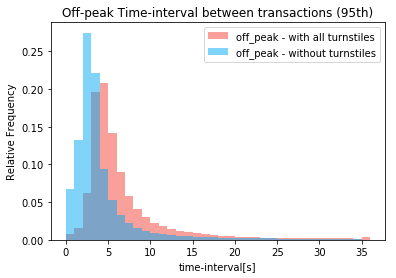

In [21]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(off_peak_turnstile_values,normed=True,bins=bins,color=colors[0], alpha=0.5, label='off_peak - with all turnstiles')
plot2 = ax.hist(off_peak_no_turnstile_values,normed=True,bins=bins,color=colors[1], alpha = 0.5, label='off_peak - without turnstiles')


ax.set_title('Off-peak Time-interval between transactions (95th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/OFFPEAK-2017-03-01.pdf')
plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/OFFPEAK-2017-03-01.pdf')

* PEAK: turns vs. without turns

In [22]:
peak_max_95 = max(peak_turnstile_95,peak_no_turnstile_95).total_seconds()
bins = range(0,int(peak_max_95),1)

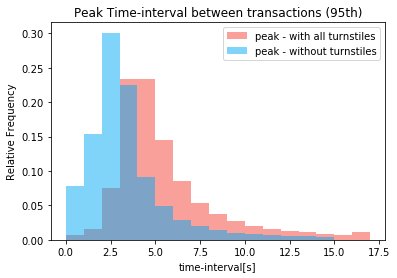

In [23]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(peak_turnstile_values,normed=True,bins=bins,color=colors[0], alpha=0.5, label='peak - with all turnstiles')
plot2 = ax.hist(peak_no_turnstile_values,normed=True,bins=bins,color=colors[1], alpha = 0.5, label='peak - without turnstiles')


ax.set_title('Peak Time-interval between transactions (95th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/PEAK-2017-03-01.pdf')
plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/PEAK-2017-03-01.pdf')

* TURNS: PEAK vs. OFF-PEAK

In [24]:
turns_max_95 = max(off_peak_turnstile_95,peak_turnstile_95).total_seconds()
bins = range(0,int(turns_max_95),1)

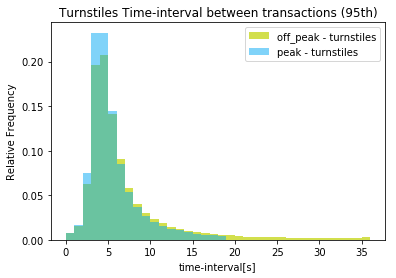

In [25]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(off_peak_turnstile_values,normed=True,bins=bins,color=colors[2], alpha=0.9, label='off_peak - turnstiles')
plot2 = ax.hist(peak_turnstile_values,normed=True,bins=bins,color=colors[1], alpha = 0.5, label='peak - turnstiles')


ax.set_title('Turnstiles Time-interval between transactions (95th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/turnstiles_peakoffpeak-2017-03-01.pdf')
plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/turnstiles_peakoffpeak-2017-03-01.pdf')

* NO-TURNS: PEAK VS. OFF-PEAK

In [26]:
no_turns_max_95 = max(off_peak_no_turnstile_95,peak_no_turnstile_95).total_seconds()
bins = range(0,int(no_turns_max_95),1)

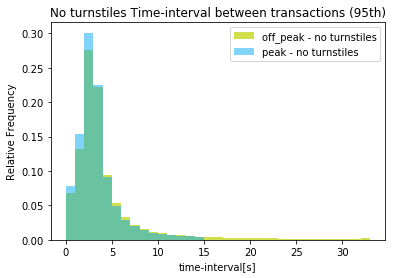

In [27]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(off_peak_no_turnstile_values,normed=True,bins=bins,color=colors[2], alpha=0.9, label='off_peak - no turnstiles')
plot2 = ax.hist(peak_no_turnstile_values,normed=True,bins=bins,color=colors[1], alpha = 0.5, label='peak - no turnstiles')


ax.set_title('No turnstiles Time-interval between transactions (95th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/no-turnstiles_peakoffpeak-2017-03-01.pdf')
plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/no-turnstiles_peakoffpeak-2017-03-01.pdf')